# Feminism 

https://medium.com/aimonks/building-a-simple-text-classifier-using-large-language-models-1a6acadcee7d

In [1]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
 
# Just fill this with wherever is your main data folder is (copy the path just before 'MovieSummaries'):
file_source = '/Volumes/LaCie/ADA/2024/Projet/'
#"/Users/Mathieu/Documents/Docs epfl/Semester3/Advanced Data Analysis (ADA)/Test VSCode/ada-2024-project-theadavengers 2/"

# Same goes for the reviews dataset : but simply copy the entire path of where your reviews data is... 
reviews_path = '/Users/shrinidhivelan/Downloads/TMDB_movie_dataset_v11.csv'
#"/Users/Mathieu/Downloads/reviews dataset/TMDB_movie_dataset_v11.csv"

# replace the following by the direct path of where  [(2) bechdel test dataset] your bechdel test movie data is:
bechdel_path = '/Users/shrinidhivelan/Desktop/DATA ADA Projet/movies.csv'#'/Users/shrinidhivelan/Downloads/movies.csv'
#"/Users/Mathieu/Downloads/movies.csv"

# replace the following by the direct path of where  [(1) feminism dataset] your bechdel test movie data is:
bechdel_path2 = "/Users/shrinidhivelan/Desktop/DATA ADA Projet/(1) Feminism/movies.csv"

### creating dataset by extracting the main CMU data ###
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_Movie = create_datasets(file_source, reviews_path)

reviews = pd.read_csv(reviews_path)

MovieMetadata_df['Country dictionnaire'] = MovieMetadata_df['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Genre dictionnaire'] = MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Language dictionnaire'] = MovieMetadata_df['Movie languages (Freebase ID:name tuples)'].apply(ast.literal_eval)


### Merge the movie summaries with movie names 

movie_names_summaries_df = pd.merge(plot_summaries_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')
movie_names_character_df = pd.merge(CharacterMetadata_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')


### Bechdel data - the scores of the bechdel tests
bechdel_2= pd.read_csv(bechdel_path2)
Movie_data_bechdel_notation_df = pd.merge(MovieMetadata_df, bechdel_2[["title", "year", "bt_score"]], left_on="Movie name", right_on="title", how="inner")


### Data to do labels for model (using texts):
summaries_bechdel_movies_df = pd.merge(plot_summaries_df, Movie_data_bechdel_notation_df, on='Wikipedia movie ID', how='inner')
summaries_label = summaries_bechdel_movies_df[['Summaries', 'Movie name', 'bt_score']]


ModuleNotFoundError: No module named 'helpers'

In [2]:
feminism_indicator = summaries_label.copy()
feminism_indicator['feminism'] = feminism_indicator['bt_score'].apply(lambda x: 1 if x == 3 else 0)

In [3]:
from datasets import Dataset

# Create a dictionary from your DataFrame
data_dict = {
    'Summaries': feminism_indicator['Summaries'].tolist(),
    'feminism': feminism_indicator['feminism'].tolist()
}

# Create a dataset from the dictionary
dataset = Dataset.from_dict(data_dict)

# Check the dataset
print(dataset)

Dataset({
    features: ['Summaries', 'feminism'],
    num_rows: 5989
})


In [4]:
# Splitting into train and test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
test_dataset = dataset['test']

In [5]:
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Sample data
print(train_dataset[0])

Training samples: 4791
Testing samples: 1198
{'Summaries': '{{Overly detailed}} Snow White\'s mother died in child birth, and her father, the King , marries Clementianna , the most beautiful woman in the land and raises Snow White. One day, the king leaves to fight a great evil that has invaded the land but never returns. He leaves Snow White a golden dagger as a parting gift. Queen Clementianna rules in his absence and deciding that "snow must do what snow does best, snow must fall," she locks her in the palace. Ten years later Snow White  has just turned eighteen and while Queen Clementianna does not care for her, the palace staff loves her, especially the baker Margaret . Margaret tells Snow White that the kingdom is rightfully hers and that she should go outside and see what has become of her people. Snow White then defies the Queen\'s orders and leaves the palace, intent on seeing the conditions of her kingdom. In the forest, she meets Prince Andrew Alcott  and his companion Charl

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT2 does not have a pad token by default

def tokenize(batch):
    return tokenizer(batch['Summaries'], padding=True, truncation=True, max_length=128)

In [7]:
def tokenize(batch):
    return tokenizer(batch['Summaries'], padding=True, truncation=True, max_length=128)

In [8]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Setting format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'feminism'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'feminism'])

Map:   0%|          | 0/4791 [00:00<?, ? examples/s]

Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

In [9]:
from transformers import GPT2Model

gpt_model = GPT2Model.from_pretrained('gpt2')

In [2]:
import torch
import torch.nn as nn

class GPTClassifier(nn.Module):
    def __init__(self, gpt_model, num_classes):
        super(GPTClassifier, self).__init__()
        self.gpt = gpt_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.gpt.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
        # Using the last hidden state of the last token
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, -1, :]  # (batch_size, hidden_size)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [3]:
num_classes = 2  # 'spam' or 'ham'
model = GPTClassifier(gpt_model, num_classes)

NameError: name 'gpt_model' is not defined

In [12]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

/Users/shrinidhivelan/miniconda3/envs/ada/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct_predictions = 0
    
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['feminism'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)
    
    return total_loss / len(loader), correct_predictions.double() / len(loader.dataset)

def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['feminism'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
    
    return total_loss / len(loader), correct_predictions.double() / len(loader.dataset)

In [14]:
num_epochs = 3
best_accuracy = 0

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = eval_model(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Saving the best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_model_state.bin')

Epoch 1/3


100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


Train Loss: 0.6352, Train Acc: 0.6525
Test Loss: 0.5884, Test Acc: 0.6970
Epoch 2/3


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]


Train Loss: 0.5562, Train Acc: 0.7178
Test Loss: 0.5699, Test Acc: 0.6945
Epoch 3/3


100%|██████████| 150/150 [02:18<00:00,  1.09it/s]

Train Loss: 0.4839, Train Acc: 0.7629
Test Loss: 0.6538, Test Acc: 0.6703


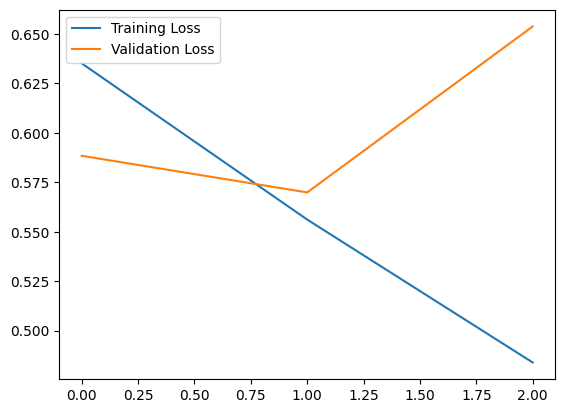

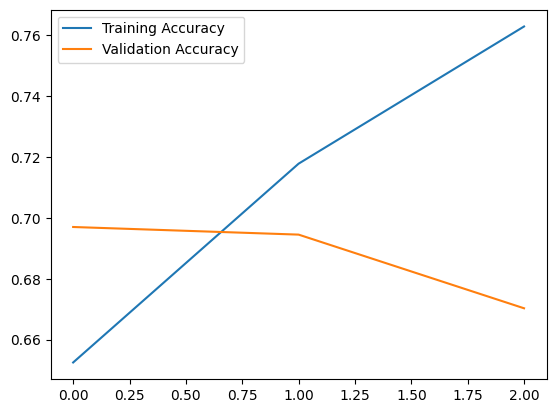

In [15]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

In [16]:
model.load_state_dict(torch.load('best_model_state.bin'))

/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_53482/3345549263.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_

<All keys matched successfully>

In [17]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['feminism'].to(device)
        
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.63      0.84      0.72       555
           1       0.80      0.58      0.67       643

    accuracy                           0.70      1198
   macro avg       0.72      0.71      0.70      1198
weighted avg       0.72      0.70      0.69      1198



In [62]:
def predict_text(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        label = 1 if preds.item() == 1 else 0
    return label

# Trial
sample_text = 'Conflict and Conquest: Central to a feminine plot is a clear conflict, often framed as a battle or competition. The hero may confront external forces (like friends, societal expectations, or natural obstacles) or internal strength (like personal flaws or emotional growth).'
print(f"Message: {sample_text}")
print(f"Prediction: {predict_text(sample_text)}")

Message: Conflict and Conquest: Central to a feminine plot is a clear conflict, often framed as a battle or competition. The hero may confront external forces (like friends, societal expectations, or natural obstacles) or internal strength (like personal flaws or emotional growth).
Prediction: 0


In [78]:
from tqdm import tqdm
#movie_names_summaries_df['feminism'] = movie_names_summaries_df['Summaries'].apply(lambda x: predict_text(x))
table_summaries = movie_names_summaries_df['Summaries'].values
table_predictions = []

for summary in tqdm(table_summaries, desc="Processing Summaries"):
    table_predictions.append(predict_text(summary))


Processing Summaries: 100%|██████████| 42303/42303 [1:44:49<00:00,  6.73it/s]  


In [80]:
movie_names_summaries_df['feminism'] = table_predictions

In [82]:
movie_names_summaries_df.to_csv('movies_gpt2_prediction.csv')

In [84]:
len(movie_names_summaries_df[movie_names_summaries_df['feminism'] == 0])/len(movie_names_summaries_df)

0.6769259863366665

In [ ]:
import pandas as pd
from gpt.feminism_gpt_classifier import train_feminism_classifier

feminism_indicator = summaries_label.copy()
feminism_indicator['feminism'] = feminism_indicator['bt_score'].apply(lambda x: 1 if x == 3 else 0)

# Train the model
model, metrics = train_feminism_classifier(feminism_indicator)


# Here is the entire pipeline for reusability

In [ ]:
from datasets import Dataset
from transformers import GPT2Tokenizer
from transformers import GPT2Model
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
import torch.nn as nn

feminism_indicator = summaries_label.copy()
feminism_indicator['feminism'] = feminism_indicator['bt_score'].apply(lambda x: 1 if x == 3 else 0)


"""
Insert your table where you want to train the model for feminism classification :
    - It should have a column Summaries (if not replace the name of the column by Summaries) for the summaries
    - It should have a column feminism (if not replace the name of the column) which corresponds to the labels
"""

# Create a dictionary from your DataFrame
data_dict = {
    'Summaries': feminism_indicator['Summaries'].tolist(),
    'feminism': feminism_indicator['feminism'].tolist()
}

# Create a dataset from the dictionary
dataset = Dataset.from_dict(data_dict)

# Check the dataset
print(dataset)

# Splitting into train and test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
test_dataset = dataset['test']


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT2 does not have a pad token by default

def tokenize(batch):
    return tokenizer(batch['Summaries'], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Setting format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'feminism'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'feminism'])


gpt_model = GPT2Model.from_pretrained('gpt2')

class GPTClassifier(nn.Module):
    def __init__(self, gpt_model, num_classes):
        super(GPTClassifier, self).__init__()
        self.gpt = gpt_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.gpt.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
        # Using the last hidden state of the last token
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, -1, :]  # (batch_size, hidden_size)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

num_classes = 2  
model = GPTClassifier(gpt_model, num_classes)


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct_predictions = 0
    
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['feminism'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)
    
    return total_loss / len(loader), correct_predictions.double() / len(loader.dataset)

def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['feminism'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
    
    return total_loss / len(loader), correct_predictions.double() / len(loader.dataset)

num_epochs = 3
best_accuracy = 0

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = eval_model(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Saving the best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_model_state.bin')